In [38]:
from statistics import correlation

from tensorflow.python.ops.metrics_impl import sensitivity_at_specificity

seed = 3906303

In [39]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random

In [40]:
csv_file_path = r"C:\Users\Jannik Ernst\Desktop\Semester 1 - 2025\Programming Project\CSV FIles\chartEventsPred.csv"
df = pd.read_csv(csv_file_path)
df.head()

,subject_id,label,charttime,glucose,next_glucose,mean_last3,std_last3,trend,BUN,Blood Pressure,Creatinine,Diastolic Blood Pressure,Heart Rate,Hemoglobin,O2 saturation pulseoxymetry,PTT,Respiratory Rate,Sodium (serum),Systolic Blood Pressure,WBC
0,10000690,normal,2150-11-03 02:56:00,77.0,84.0,77.000000,NaN,NaN,20.2,74.93617,0.82,60.361702,84.072917,10.175,95.702128,NaN,22.557895,135.2,122.893617,6.35
1,10000690,normal,2150-11-04 03:03:00,84.0,117.0,80.500000,4.949747,7.0,20.2,74.93617,0.82,60.361702,84.072917,10.175,95.702128,NaN,22.557895,135.2,122.893617,6.35
2,10000690,normal,2150-11-04 10:00:00,117.0,120.0,92.666667,21.361960,33.0,20.2,74.93617,0.82,60.361702,84.072917,10.175,95.702128,NaN,22.557895,135.2,122.893617,6.35
3,10000690,normal,2150-11-04 17:54:00,120.0,107.0,107.000000,19.974984,3.0,20.2,74.93617,0.82,60.361702,84.072917,10.175,95.702128,NaN,22.557895,135.2,122.893617,6.35
4,10000690,normal,2150-11-05 05:36:00,107.0,97.0,114.666667,6.806859,-13.0,20.2,74.93617,0.82,60.361702,84.072917,10.175,95.702128,NaN,22.557895,135.2,122.893617,6.35


In [41]:
df.shape

(1050293, 20)

In [42]:
df.dropna(inplace=True)
df.shape

(982510, 20)

In [43]:
df.head()

,subject_id,label,charttime,glucose,next_glucose,mean_last3,std_last3,trend,BUN,Blood Pressure,Creatinine,Diastolic Blood Pressure,Heart Rate,Hemoglobin,O2 saturation pulseoxymetry,PTT,Respiratory Rate,Sodium (serum),Systolic Blood Pressure,WBC
7,10001217,normal,2157-12-19 22:00:00,145.0,113.0,129.000000,22.627417,32.0,9.500000,88.673469,0.450000,77.720000,86.711538,11.750000,95.019231,32.700000,19.038462,138.5,126.900000,13.70
9,10001725,normal,2110-04-11 18:02:00,146.0,152.0,153.500000,10.606602,-15.0,17.000000,70.062500,0.800000,61.187500,79.156250,13.250000,98.225806,30.600000,17.531250,139.0,100.406250,18.55
11,10001884,normal,2131-01-11 06:37:00,140.0,145.0,144.000000,5.656854,-8.0,26.785714,90.529412,0.885714,74.669683,70.800000,8.670588,97.648649,58.061765,19.044444,136.5,129.176471,12.78
12,10001884,hyper,2131-01-12 03:34:00,145.0,199.0,144.333333,4.041452,5.0,26.785714,90.529412,0.885714,74.669683,70.800000,8.670588,97.648649,58.061765,19.044444,136.5,129.176471,12.78
13,10001884,normal,2131-01-13 04:29:00,199.0,177.0,161.333333,32.715949,54.0,26.785714,90.529412,0.885714,74.669683,70.800000,8.670588,97.648649,58.061765,19.044444,136.5,129.176471,12.78


In [44]:
# Drop outliers of next_glucose and glucose:
df = df[(df['next_glucose'] >= 10) & (df['next_glucose'] <= 2656)]
df = df[(df['glucose'] >= 10) & (df['glucose'] <= 2656)]
df.shape

(982510, 20)

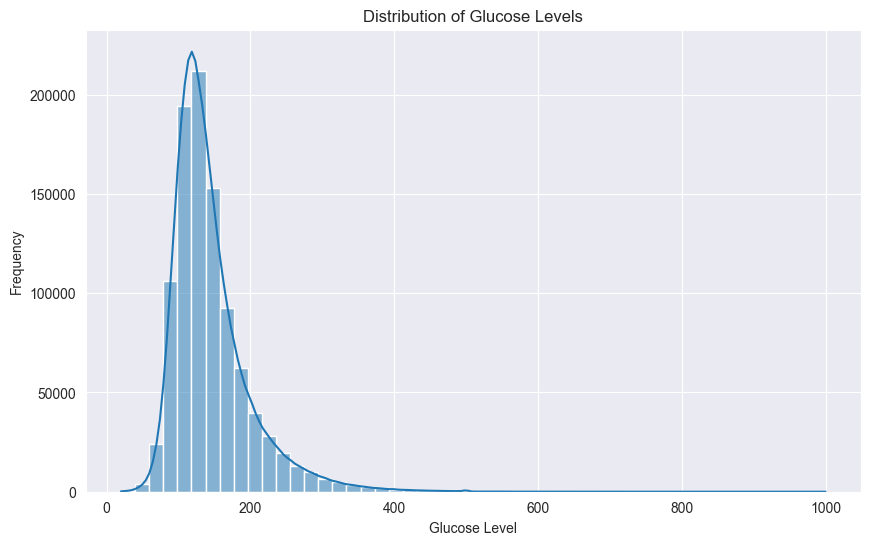

In [45]:
# Check the distribution of glucose - log scale
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(df['next_glucose'], bins=50, kde=True)
plt.title('Distribution of Glucose Levels')
plt.xlabel('Glucose Level')
plt.ylabel('Frequency')
plt.show()

In [46]:
# Check what the minimum next_glucose value is
min_next_glucose = df['next_glucose'].min()
print(f'Minimum next_glucose value: {min_next_glucose}')
print(f'Num. of min value occurrences: {len(df[df["next_glucose"] == min_next_glucose])}')

Minimum next_glucose value: 20.0
Num. of min value occurrences: 42


In [47]:
# Check what the maximum next_glucose value is
max_next_glucose = df['next_glucose'].max()
print(f'Minimum next_glucose value: {max_next_glucose}')
print(f'Num. of min value occurrences: {len(df[df["next_glucose"] == max_next_glucose])}')

Minimum next_glucose value: 1000.0
Num. of min value occurrences: 2


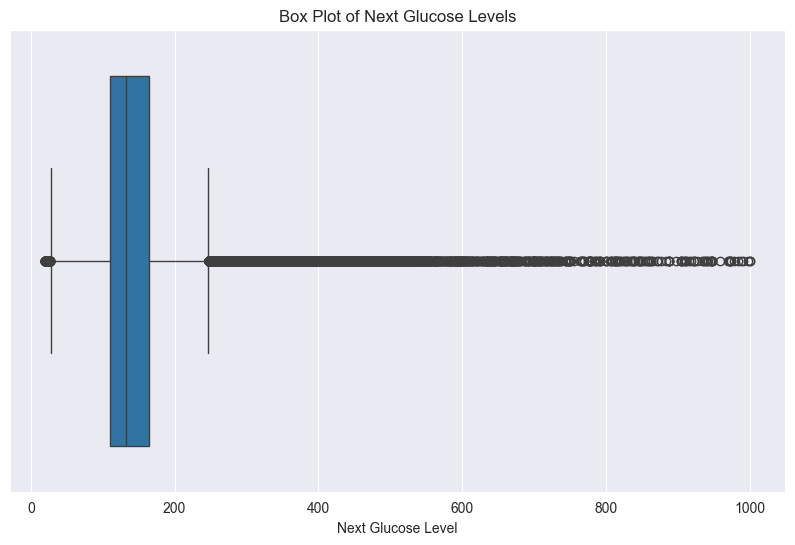

In [48]:
# Box plot to visualize the distribution of next_glucose
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['next_glucose'])
plt.title('Box Plot of Next Glucose Levels')
plt.xlabel('Next Glucose Level')
plt.show()

In [49]:
# Remove outliers based on the box plot
Q1 = df['next_glucose'].quantile(0.25)
Q3 = df['next_glucose'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['next_glucose'] >= Q1 - 1.5 * IQR) & (df['next_glucose'] <= Q3 + 1.5 * IQR)]
df.shape

(929491, 20)

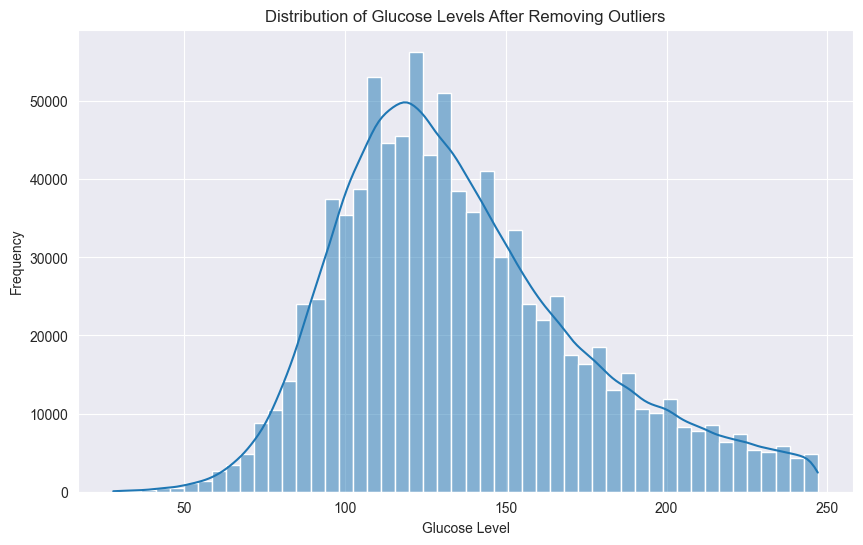

In [50]:
# check distribution of glucose again after removing outliers
plt.figure(figsize=(10, 6))
sns.histplot(df['next_glucose'], bins=50, kde=True)
plt.title('Distribution of Glucose Levels After Removing Outliers')
plt.xlabel('Glucose Level')
plt.ylabel('Frequency')
plt.show()

In [51]:
# Check num of unique patients
df['subject_id'].nunique()
print(len(df['subject_id'].unique()))

35189


In [52]:
print(type(df))
df.head()

<class 'pandas.core.frame.DataFrame'>


,subject_id,label,charttime,glucose,next_glucose,mean_last3,std_last3,trend,BUN,Blood Pressure,Creatinine,Diastolic Blood Pressure,Heart Rate,Hemoglobin,O2 saturation pulseoxymetry,PTT,Respiratory Rate,Sodium (serum),Systolic Blood Pressure,WBC
7,10001217,normal,2157-12-19 22:00:00,145.0,113.0,129.000000,22.627417,32.0,9.500000,88.673469,0.450000,77.720000,86.711538,11.750000,95.019231,32.700000,19.038462,138.5,126.900000,13.70
9,10001725,normal,2110-04-11 18:02:00,146.0,152.0,153.500000,10.606602,-15.0,17.000000,70.062500,0.800000,61.187500,79.156250,13.250000,98.225806,30.600000,17.531250,139.0,100.406250,18.55
11,10001884,normal,2131-01-11 06:37:00,140.0,145.0,144.000000,5.656854,-8.0,26.785714,90.529412,0.885714,74.669683,70.800000,8.670588,97.648649,58.061765,19.044444,136.5,129.176471,12.78
12,10001884,hyper,2131-01-12 03:34:00,145.0,199.0,144.333333,4.041452,5.0,26.785714,90.529412,0.885714,74.669683,70.800000,8.670588,97.648649,58.061765,19.044444,136.5,129.176471,12.78
13,10001884,normal,2131-01-13 04:29:00,199.0,177.0,161.333333,32.715949,54.0,26.785714,90.529412,0.885714,74.669683,70.800000,8.670588,97.648649,58.061765,19.044444,136.5,129.176471,12.78


In [53]:
cor = df.copy()
print(type(cor))
cor.drop(columns=['subject_id', 'label', 'charttime'], inplace=True)
cor.head()

<class 'pandas.core.frame.DataFrame'>


,glucose,next_glucose,mean_last3,std_last3,trend,BUN,Blood Pressure,Creatinine,Diastolic Blood Pressure,Heart Rate,Hemoglobin,O2 saturation pulseoxymetry,PTT,Respiratory Rate,Sodium (serum),Systolic Blood Pressure,WBC
7,145.0,113.0,129.000000,22.627417,32.0,9.500000,88.673469,0.450000,77.720000,86.711538,11.750000,95.019231,32.700000,19.038462,138.5,126.900000,13.70
9,146.0,152.0,153.500000,10.606602,-15.0,17.000000,70.062500,0.800000,61.187500,79.156250,13.250000,98.225806,30.600000,17.531250,139.0,100.406250,18.55
11,140.0,145.0,144.000000,5.656854,-8.0,26.785714,90.529412,0.885714,74.669683,70.800000,8.670588,97.648649,58.061765,19.044444,136.5,129.176471,12.78
12,145.0,199.0,144.333333,4.041452,5.0,26.785714,90.529412,0.885714,74.669683,70.800000,8.670588,97.648649,58.061765,19.044444,136.5,129.176471,12.78
13,199.0,177.0,161.333333,32.715949,54.0,26.785714,90.529412,0.885714,74.669683,70.800000,8.670588,97.648649,58.061765,19.044444,136.5,129.176471,12.78


In [54]:
correlation_matrix = cor.corr()
print(type(correlation_matrix))
correlation_matrix.shape

<class 'pandas.core.frame.DataFrame'>


(17, 17)

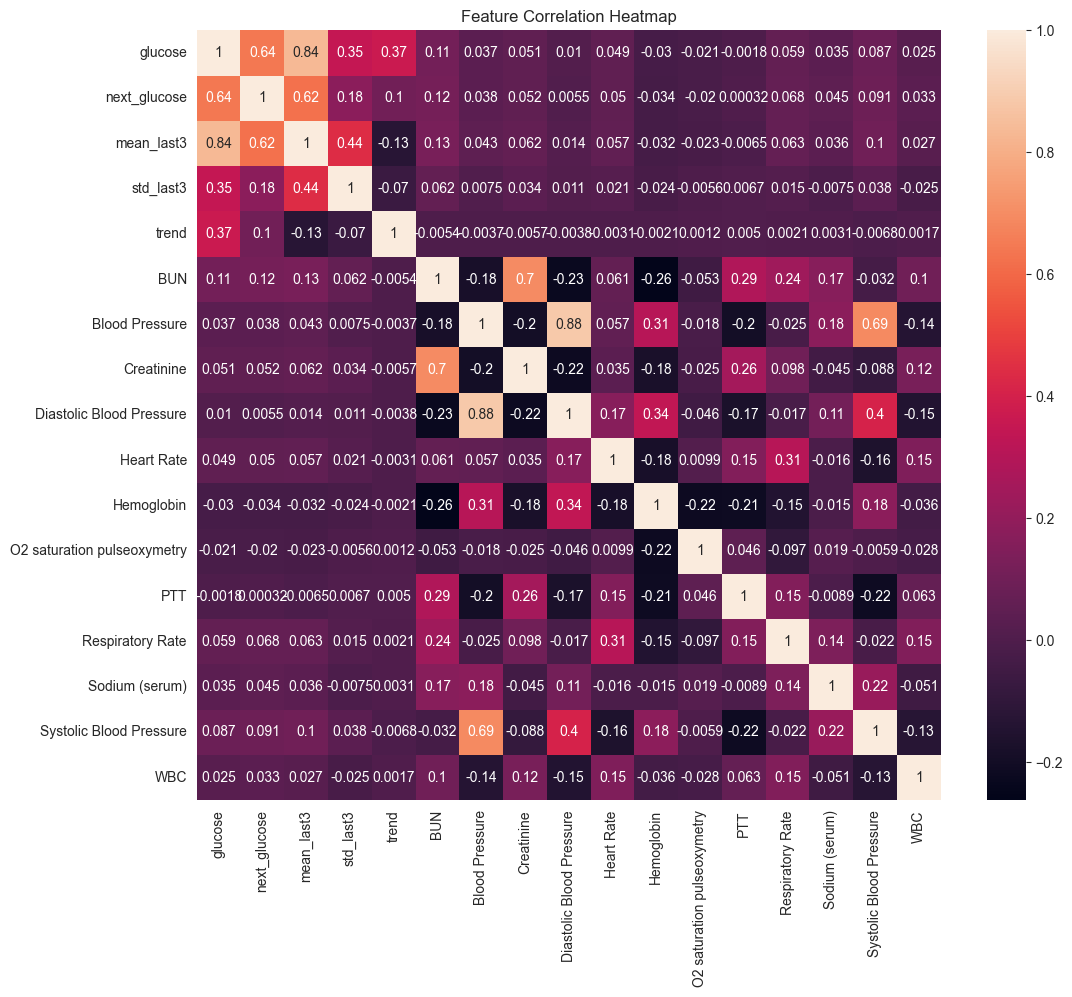

In [55]:
# Create a heatmap of feature correlations
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True)
plt.title('Feature Correlation Heatmap')
plt.show()

In [56]:
# Find features with high correlation with each other (above 0.6)
high_corr_features = set()
threshold = 0.6
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            print(f"{correlation_matrix.columns[i]} and {correlation_matrix.columns[j]}: {correlation_matrix.iloc[i, j]}")
            print("")


next_glucose and glucose: 0.6416607633535296

mean_last3 and glucose: 0.8366923036555264

mean_last3 and next_glucose: 0.622203082684205

Creatinine and BUN: 0.6983693654949642

Diastolic Blood Pressure and Blood Pressure: 0.8832903827108283

Systolic Blood Pressure and Blood Pressure: 0.6895079020134709



In [58]:
df_sample = df.copy()
df_sample.drop(columns=['trend', 'std_last3', 'Sodium (serum)', 'Creatinine', 'Hemoglobin', 'PTT', 'BUN', 'WBC', 'O2 saturation pulseoxymetry'], inplace=True)

In [59]:
## Do svr on the data
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler

In [64]:
# df_sample.shape
# df_sample = df.copy()  # Use the entire dataset for now
df_sample = df_sample.sample(frac=0.5, random_state=seed)  # Sample 50% of the data for faster processing

In [65]:
# check the number of each patient type - hypo, hyper, normal
df_sample['label'].value_counts()
print(df_sample['label'].value_counts())

label
normal    236890
hyper      38264
hypo        3693
Name: count, dtype: int64


In [66]:
import pandas as pd
import numpy as np

# Step 1: Count label frequencies
label_counts = df_sample['label'].value_counts()

# Step 2: Compute inverse frequency weights
inv_freq = 1.0 / label_counts

# Step 3: Map sample weights to each row
df_sample['sample_weight'] = df_sample['label'].map(inv_freq)

# Step 4 (optional): Normalize to keep weights in a similar scale
df_sample['sample_weight'] *= len(df_sample) / df_sample['sample_weight'].sum()


In [67]:
# Split into train test

X = df_sample.drop(columns=['subject_id', 'next_glucose', 'label', 'charttime'])
y = df_sample['next_glucose']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
X_train.shape

(223077, 8)

In [68]:
from sklearn.preprocessing import StandardScaler

# Step 1: Separate sample weights
sample_weight_train = X_train['sample_weight'].values
sample_weight_test = X_test['sample_weight'].values

# Step 2: Drop sample_weight from the features
X_train_features = X_train.drop(columns=['sample_weight'])
X_test_features = X_test.drop(columns=['sample_weight'])

# Step 3: Scale features only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)
X_train_scaled[:5]

array([[ 0.25473295,  1.68493772,  0.19030169,  0.13542673, -0.91584663,
         0.14500533,  0.40424556],
       [-0.80221083, -0.3716224 ,  0.77350578,  0.98635085, -1.45267883,
        -1.58497952,  0.13641434],
       [-0.39742385, -1.04062389, -1.13438128, -0.94354523,  0.80680748,
        -0.64874401,  0.10930019],
       [ 1.82890454,  2.99816286, -0.28456879,  0.01719136,  0.23340226,
        -1.30873396, -0.28855003],
       [-1.81417828, -1.04888317, -1.35918973, -1.68084191, -0.74554829,
         0.41998012, -0.46578125]])

In [32]:
sample_weight_train[:5]

array([ 2.42915011,  0.39237199,  0.39237199,  0.39237199, 25.16896832])

In [33]:
# Train the SVR model

print("Training SVR model...")
svr = SVR(kernel='rbf', C=1.0, epsilon=0.1)
svr.fit(X_train_scaled, y_train, sample_weight=sample_weight_train)
print("Model training complete.")

Training SVR model...
Model training complete.


In [34]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print("Evaluating model performance...")
# Predict
y_pred = svr.predict(X_test_scaled)

# Weighted metrics
mse = mean_squared_error(y_test, y_pred, sample_weight=sample_weight_test)
mae = mean_absolute_error(y_test, y_pred, sample_weight=sample_weight_test)
r2 = r2_score(y_test, y_pred, sample_weight=sample_weight_test)
print("Model evaluation complete.")
print(f"Weighted MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")


Evaluating model performance...
Model evaluation complete.
Weighted MSE: 1622.4145, MAE: 27.1099, R²: 0.5925


In [35]:
rmse = root_mean_squared_error(y_test, y_pred, sample_weight=sample_weight_test)
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 40.27920631895191


              precision    recall  f1-score   support

       hyper      0.493     0.676     0.570      7589
        hypo      0.136     0.475     0.211       755
      normal      0.935     0.842     0.886     47426

    accuracy                          0.815     55770
   macro avg      0.521     0.665     0.556     55770
weighted avg      0.864     0.815     0.834     55770



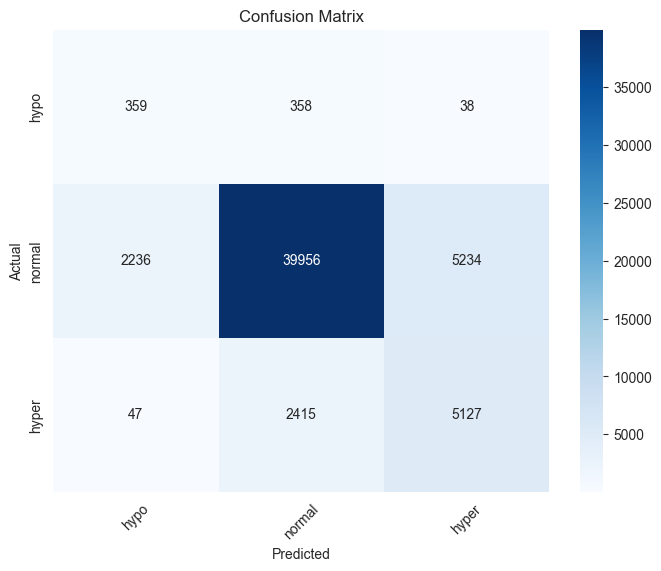

Sensitivity and Specificity per class:
Hypo — Sensitivity: 0.475, Specificity: 0.959
Normal — Sensitivity: 0.842, Specificity: 0.668
Hyper — Sensitivity: 0.676, Specificity: 0.891


In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# 1. Classification function
def classify_glucose(value):
    if value < 70:
        return 'hypo'
    elif value > 180:
        return 'hyper'
    else:
        return 'normal'

# 2. Apply classification
y_pred_classified = [classify_glucose(value) for value in y_pred]
y_test_classified = [classify_glucose(value) for value in y_test]

# 3. Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Actual': y_test_classified,
    'Predicted': y_pred_classified
})

# 4. Print classification report
print(classification_report(comparison_df['Actual'], comparison_df['Predicted'], digits=3))

# 5. Confusion Matrix and Plot
labels = ['hypo', 'normal', 'hyper']
conf_matrix = confusion_matrix(comparison_df['Actual'], comparison_df['Predicted'], labels=labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(rotation=45)
plt.show()

# 6. Sensitivity and Specificity Calculation
print("Sensitivity and Specificity per class:")
for i, label in enumerate(labels):
    TP = conf_matrix[i, i]
    FN = np.sum(conf_matrix[i, :]) - TP
    FP = np.sum(conf_matrix[:, i]) - TP
    TN = np.sum(conf_matrix) - (TP + FN + FP)

    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

    print(f"{label.capitalize()} — Sensitivity: {sensitivity:.3f}, Specificity: {specificity:.3f}")
